In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from scipy.stats import beta, norm
from scipy.stats import t as t_distribution
from scipy.special import beta as beta_function
from scipy.special import gamma as gamma_function
np.random.seed(42)

### **Control Variates Variance Reduction Technique**


### **Control Variates Method**
Let $Y$ be the random variable representing the Monte Carlo estimate of the option price. Suppose we have another random variable $Z$ (the **control variate**) that is highly correlated with $Y$ and has a known expectation $\mathbb{E}[Z]$.

Define a new estimator:

$$
X = Y - \beta (Z - \mathbb{E}[Z])
$$

for some coefficient $\beta$.

Since $\mathbb{E}[X] = \mathbb{E}[Y]$ for any $\beta$, the expectation remains unchanged, but the **variance of $X$ can be minimized** by choosing an optimal $\beta$.

---

### **Derivation of the Optimal $\beta^*$**
To minimize the variance of $X$, we compute:

$$
\text{Var}(X) = \text{Var}(Y - \beta (Z - \mathbb{E}[Z]))
$$

Expanding using variance properties:

$$
\text{Var}(X) = \text{Var}(Y) + \beta^2 \text{Var}(Z) - 2\beta \text{Cov}(Y, Z)
$$

Taking the derivative with respect to $\beta$ and setting it to zero:

$$
\frac{d}{d\beta} \text{Var}(X) = 2\beta \text{Var}(Z) - 2\text{Cov}(Y, Z) = 0
$$

Solving for $\beta^*$:

$$
\beta^* = \frac{\text{Cov}(Y, Z)}{\text{Var}(Z)}
$$

This choice minimizes the variance of the estimator.

---

### **Variance Reduction**
The variance of the new estimator $X$ is:

$$
\text{Var}(X) = \text{Var}(Y) (1 - \rho^2),
$$

where $\rho = \frac{\text{Cov}(Y, Z)}{\sigma_Y \sigma_Z}$ is the correlation between $Y$ and $Z$.

Since $\rho^2 \leq 1$, the variance of $X$ is always **lower** than that of $Y$ unless $Y$ and $Z$ are completely uncorrelated.

---

### **Applying Control Variates to a Lookback Option with Fixed Strike**
A **lookback call option with fixed strike** has the payoff:

$$
\max_{t \in [0,T]}(S_t) - K
$$

where $\max_{t \in [0,T]}(S_t)$ is the maximum price of the asset during the option's lifetime.

Since lookback options are more expensive than standard European calls, and they are highly correlated with them, we can use the price of a **standard European call** as a control variate.

#### **Step-by-Step Approach:**
1. **Define the Monte Carlo Estimator for the Lookback Call Option**  
   Simulate asset paths under the Black-Scholes model and compute:

   $$
   Y = e^{-rT} (\max(S_t) - K)^+
   $$

2. **Define the Control Variate (European Call Price)**  
   The European call price has a closed-form Black-Scholes solution:

   $$
   C_{\text{BS}} = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)
   $$

   where:

   $$
   d_1 = \frac{\ln(S_0/K) + (r - q + \frac{1}{2} \sigma^2)T}{\sigma\sqrt{T}}, \quad
   d_2 = d_1 - \sigma\sqrt{T}
   $$

   Define:

   $$
   Z = e^{-rT} (S_T - K)^+
   $$

   which is the Monte Carlo estimate for the European call.

3. **Compute the Optimal $\beta^*$**
   In fact we can't calculate the coefficient analitycally, so we'll use it's statistical approximation

4. **Adjust the Monte Carlo Estimate**
   Use the control variates estimator:

   $$
   X = Y - \beta^*(Z - C_{\text{BS}})
   $$


In [14]:
Normal_pdf = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * Normal_pdf(d1) - K * np.exp(-r*T)* Normal_pdf(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*Normal_pdf(-d2) - S*Normal_pdf(-d1)

def CALL_sampling(S, K, T, r, sigma, N):
    Z = np.random.normal(size = N)
    S_T = S * np.exp((r - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z)
    Call = np.max([S_T - K, np.zeros(N)], axis=0)
    return Call.mean() * np.exp(- r * T), Call.std() * np.exp(-r * T) * t_distribution.ppf(0.99, N-1) / np.sqrt(N)

def naive_monte_carlo_lookback_put(S0, T, r, sigma, N, M, q):
    dt = T / M
    payoffs = np.zeros(N)
    S = np.zeros(shape=N)
    S[:] = S0
    max_S = S
    for _ in range(M):
        # Simulate next asset price step
        Z = np.random.normal(size=N)
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        max_S = np.max([max_S,S[:]], axis=0)
    # Compute payoff if barrier is not hit
    payoff = np.max([max_S - S, np.zeros(N)], axis=0)
    price = np.exp(-r * T) * payoff.mean(), np.exp(-r * T) * payoff.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)
    return price

def sample_brownian_bridge_max(X0, X1, dt, b, N):
    """
    Given two log-price values X0 and X1 over a time interval dt,
    returns sample of max of brownian bridge between them.
    """
    U = np.random.uniform(size=N)
    M = (X0 + X1 + np.sqrt((X1 - X0) ** 2 - 2 * b(X0) ** 2 * dt * np.log(U))) / 2
    return M

def monte_carlo_lookback_put_with_bridge(S0, T, K, r, sigma, N, M, q):
    dt = T / M
    X = np.zeros(shape=N)
    X_next = np.zeros(shape=N)
    X[:] = np.log(S0)
    M_max = X.copy()
    for _ in range(M):
        # Simulate next asset price step
        Z = np.random.normal(size=N)
        X_next = X + (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        # Sample the maximum
        M = sample_brownian_bridge_max(X, X_next, dt, lambda x: sigma, N)
        M_max = np.max([M, M_max], axis=0)
        X = X_next
    # Compute payoff if barrier is not hit
    Y = np.max([np.exp(M_max) - K, np.zeros(N)], axis=0)
    Z = np.max([np.exp(X) - K, np.zeros(N)], axis=0)
    m = BS_CALL(S0, K, T, r, sigma)   # - мат ожидание Z

    # np.cov(Y, Z) -- это матрица ковариаций
    #  / Cov(Y,Y)  Cov(Z,Y)  \
    #  \ Cov(Y,Z)  Cov(Z,Z)  / 
    b = np.cov(Y, Z)[0,1] / Z.var()  #(можно ещё так: np.cov(Y, Z)[0,1] / np.cov(Y, Z)[1,1]) 
    payoff = Y
    price = np.exp(-r * T) * payoff.mean(), np.exp(-r * T) * payoff.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)
    return price

def monte_carlo_lookback_put_with_bridge_reduced(S0, T, K, r, sigma, N, M, q):
    dt = T / M
    X = np.zeros(shape=N)
    X_next = np.zeros(shape=N)
    X[:] = np.log(S0)
    M_max = X.copy()
    for _ in range(M):
        # Simulate next asset price step
        Z = np.random.normal(size=N)
        X_next = X + (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        # Sample the maximum
        M = sample_brownian_bridge_max(X, X_next, dt, lambda x: sigma, N)
        M_max = np.max([M, M_max], axis=0)
        X = X_next
    # Compute payoff if barrier is not hit
    Y = np.max([np.exp(M_max) - K, np.zeros(N)], axis=0)
    Z = np.max([np.exp(X) - K, np.zeros(N)], axis=0)
    m = BS_CALL(S0, K, T, r, sigma)
    b = np.cov(Y, Z)[0,1] / Z.var()
    payoff = Y - b * (Z - m)
    price = np.exp(-r * T) * payoff.mean(), np.exp(-r * T) * payoff.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)
    return price

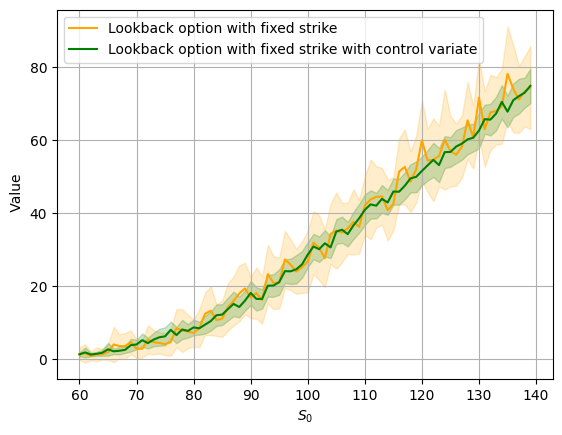

In [15]:
r = 0.05
T = 1
sigma = 0.3
N = 100
M_naive = 10
M_smart = 1
M_check = 10
q = 0.001
S = np.arange(60,140,1)
K = 100
lookback_put_sampling = np.array([monte_carlo_lookback_put_with_bridge(s, T, K, r, sigma, N, M_naive, q) for s in S])
lookback_put_sampling_with_bridge = np.array([monte_carlo_lookback_put_with_bridge_reduced(s, T, K, r, sigma, N, M_smart, q) for s in S])
# TRUE_lookback_put_prices = np.array([monte_carlo_lookback_put_with_bridge(s, T, K, r, sigma, 10_000, M_check, q) for s in S])

plt.plot(S, lookback_put_sampling[:,0], label='Lookback option with fixed strike', color = 'orange')
plt.fill_between(S, lookback_put_sampling[:,0] + lookback_put_sampling[:,1], lookback_put_sampling[:,0] - lookback_put_sampling[:,1], alpha=0.2, color = 'orange')
plt.plot(S, lookback_put_sampling_with_bridge[:,0], label='Lookback option with fixed strike with control variate', color = 'green')
plt.fill_between(S, lookback_put_sampling_with_bridge[:,0] + lookback_put_sampling_with_bridge[:,1], lookback_put_sampling_with_bridge[:,0] - lookback_put_sampling_with_bridge[:,1], alpha=0.2, color = 'green')
# plt.plot(S, TRUE_lookback_put_prices[:,0], label=' "True" lookback option price', color = 'purple')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend()

### Antithetic variates method

In [16]:
def CALL_sampling_reduced(S, K, T, r, sigma, N):
    Z = np.random.normal(size = N // 2)
    Z_ = -Z
    Z_boss = np.hstack([Z,Z_])
    S_T = S * np.exp((r - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z_boss)
    Call = np.max([S_T - K, np.zeros(N)], axis=0)
    Call_for_variance = np.vstack([Call[:N//2],Call[N//2:]]).mean(axis=0)
    # print(np.hstack([Call[:N//2],Call[N//2:]]).shape)
    return Call.mean() * np.exp(- r * T), Call_for_variance.std() * np.exp(-r * T) * t_distribution.ppf(0.99, N-1) / np.sqrt(N)

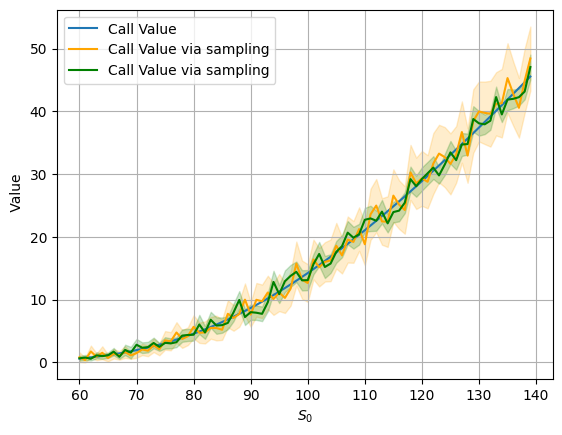

In [17]:
N = 3_00
calls = [BS_CALL(s, K, T, r, sigma) for s in S]
calls_sampling = np.array([CALL_sampling(s, K, T, r, sigma, N) for s in S])
calls_smapling_reduced = np.array([CALL_sampling_reduced(s, K, T, r, sigma, N) for s in S])
plt.plot(S, calls, label='Call Value')
plt.plot(S, calls_sampling[:,0], label='Call Value via sampling', color='orange')
plt.fill_between(S, calls_sampling[:,0] - calls_sampling[:,1], calls_sampling[:,0] + calls_sampling[:,1], alpha=0.2, color='orange')
plt.plot(S, calls_smapling_reduced[:,0], label='Call Value via sampling', color='green')
plt.fill_between(S, calls_smapling_reduced[:,0] - calls_smapling_reduced[:,1], calls_smapling_reduced[:,0] + calls_smapling_reduced[:,1], alpha=0.2, color='green')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend()

### Importance sampling method

We use the following fact from the lecture:
$$
  \mathbb{E}[f(X)] = \mathbb{E}[f(Y)e^{-\mu Y + \frac{\mu^2}{2}}]
$$
Where $X \sim \mathcal{N}(0,1)$ and $Y \sim \mathcal{N}(\mu,1)$

In [18]:
def PUT_sampling_(S, K, T, r, sigma, N):
    Z = np.random.normal(size = N)
    S_T = S * np.exp((r - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z)
    Call = np.max([K - S_T, np.zeros(N)], axis=0)
    return Call.mean() * np.exp(- r * T), Call.std() * np.exp(-r * T) / np.sqrt(N), Call

def PUT_sampling__importance(S, K, T, r, sigma, N, mu):
    Z = np.random.normal(size = N)
    Z_ = Z + mu
    logS_T = np.log(S) + (r - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z_
    # S_T = S * np.exp((r - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z)
    logS_T_adj = logS_T
    Call = np.max([K - np.exp(logS_T), np.zeros(N)], axis=0) * np.exp(-mu * Z_ + mu ** 2 / 2)
    return Call.mean() * np.exp(- r * T), Call.std() * np.exp(-r * T) / np.sqrt(N), Call

S0 = 100
r = 0.03
sigma = 0.3
K = 85
T = 1
N = 10 ** 6

In [19]:
price_vanilla, std_vanilla, calls = PUT_sampling_(S0, K, T, r, sigma, N)
print(f'price = {price_vanilla} with "std" = {std_vanilla}')

price = 4.286390310951701 with "std" = 0.008417087029758458


In [20]:
price_vanilla, std_vanilla, calls = PUT_sampling__importance(S0, K, T, r, sigma, N, -np.exp(1)/2)
print(f'price = {price_vanilla} with "std" = {std_vanilla}')

price = 4.264730975217828 with "std" = 0.0028244303182380546


In [21]:
mu = (-np.log(S0/K) - (r + sigma**2/2)*T) / (np.sqrt(T) * sigma)

mu
price_vanilla, std_vanilla, calls = PUT_sampling__importance(S0, K, T, r, sigma, N, mu)
print(f'price = {price_vanilla} with "std" = {std_vanilla}')

price = 4.265239943441059 with "std" = 0.003814341782578139
